In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from packaging import version
import sklearn
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_excel("/home/jui/thesis-code/data/credit_card_clients.xls")

def split_label(dataset, target_feature):
    X = dataset.drop([target_feature], axis=1)
    y = dataset[[target_feature]]
    return X, y

Model Accuracy: 0.8240
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      5860
           1       0.67      0.39      0.49      1640

    accuracy                           0.82      7500
   macro avg       0.76      0.67      0.69      7500
weighted avg       0.81      0.82      0.81      7500


Final Training Log Loss: 0.3043
Final Test Log Loss: 0.4250


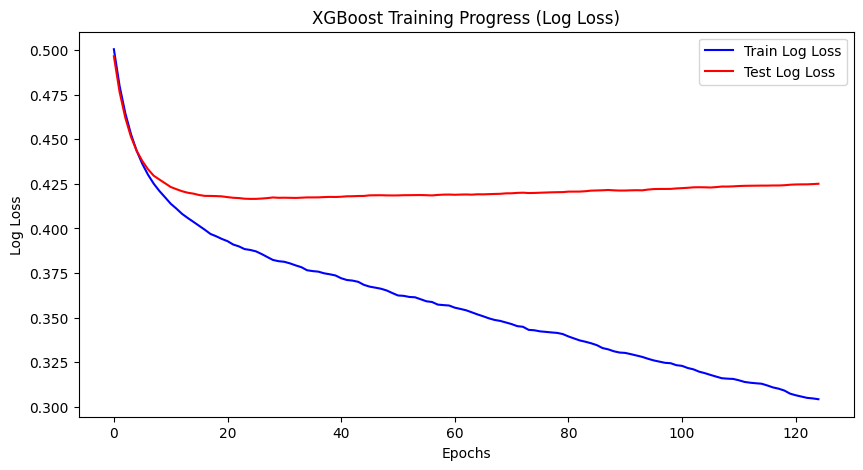

In [17]:
# Handle different scikit-learn versions for OneHotEncoder parameters
if version.parse(sklearn.__version__) < version.parse('1.2'):
    ohe_params = {"sparse": False}
else:
    ohe_params = {"sparse_output": False}

def create_classification_pipeline(X):
    pipe_cfg = {
        'num_cols': X.dtypes[X.dtypes == 'int64'].index.values.tolist(),
        'cat_cols': X.dtypes[X.dtypes == 'object'].index.values.tolist(),
    }
    num_pipe = Pipeline([ 
        ('num_imputer', SimpleImputer(strategy='median')),
        ('num_scaler', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('cat_imputer', SimpleImputer(strategy='constant', fill_value='?')),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore', **ohe_params))
    ])
    feat_pipe = ColumnTransformer([
        ('num_pipe', num_pipe, pipe_cfg['num_cols']),
        ('cat_pipe', cat_pipe, pipe_cfg['cat_cols'])
    ])

    xgb_model = xgb.XGBClassifier(
        tree_method='hist',  # Fast histogram-based training
        random_state=10,
        n_jobs=-1,  # Use all CPU cores
        learning_rate=0.16,  # Controls step size
        reg_lambda=1.1,  # L2 regularization (weight decay)
        eval_metric='logloss',
        objective='binary:logistic',  # Logarithmic loss for classification
        use_label_encoder=False,  # Avoids unnecessary warnings
        n_estimators=125
    )

    pipeline = Pipeline(steps=[('preprocessor', feat_pipe),
                               ('model', xgb_model)])

    return pipeline

target_feature = 'default payment next month'
categorical_features = []

# Split data into features and target
X, y = split_label(df, target_feature)

# Split data into train and test sets (80% training, 20% testing)
X_train_og, X_test_og, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

features = X_train_og.columns.tolist()  
classes = np.unique(y_train).tolist()  

# Create the classification pipeline
pipeline = create_classification_pipeline(X_train_og)

# Fit the preprocessor separately to extract feature names
pipeline.named_steps['preprocessor'].fit(X_train_og)

# Extract transformed feature names safely
if hasattr(pipeline.named_steps['preprocessor'], "get_feature_names_out"):
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
else:
    # Manually construct feature names (for older sklearn versions)
    num_cols = X_train_og.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X_train_og.select_dtypes(include=['object']).columns.tolist()
    feature_names = num_cols + cat_cols  # Not perfect, but works if get_feature_names_out() is missing

# Convert y_train and y_test to NumPy arrays
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Extract XGBClassifier separately and fit with eval_set
xgb_model = pipeline.named_steps['model']
model = xgb_model.fit(pipeline.named_steps['preprocessor'].transform(X_train_og), y_train, 
              eval_set=[(pipeline.named_steps['preprocessor'].transform(X_train_og), y_train),
                        (pipeline.named_steps['preprocessor'].transform(X_test_og), y_test)], verbose=False)

# Make predictions
y_pred = xgb_model.predict(pipeline.named_steps['preprocessor'].transform(X_test_og))

# Compute accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{class_report}\n")

# Extract evaluation results
evals_result = xgb_model.evals_result()

# Get the final log loss for training and testing
train_log_loss = evals_result['validation_0']['logloss'][-1]
test_log_loss = evals_result['validation_1']['logloss'][-1]

# Print the final log loss values for both training and validation
print(f"Final Training Log Loss: {train_log_loss:.4f}")
print(f"Final Test Log Loss: {test_log_loss:.4f}")

# Plot training and validation log loss
plt.figure(figsize=(10, 5))
plt.plot(evals_result['validation_0']['logloss'], label='Train Log Loss', color='blue')
plt.plot(evals_result['validation_1']['logloss'], label='Test Log Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("XGBoost Training Progress (Log Loss)")
plt.legend()
plt.show()

In [18]:
from art.estimators.classification import XGBoostClassifier
from art.attacks.evasion import ZooAttack
from art.estimators.classification import SklearnClassifier

import warnings
warnings.filterwarnings('ignore')

# Select random 7500 samples using positional indexing
subset_indices = np.random.choice(len(y_train), 7500, replace=False)
X_train_subset = X_train_og.iloc[subset_indices]  # Use .iloc for positional indexing
y_train_subset = y_train[subset_indices]  # Direct positional indexing for NumPy array


def get_adversarial_examples(X_train_subset, pipeline, model):
    """
    Generate adversarial examples using the ZooAttack method.

    Args:
        X_train_subset (np.ndarray): Subset of training data (raw features).
        y_train_subset (np.ndarray): Corresponding labels for the subset.
        pipeline (Pipeline): The original pipeline containing preprocessing and model.

    Returns:
        np.ndarray: Adversarial examples.
    """
    # Extract the preprocessor and model from the pipeline
    preprocessor = pipeline.named_steps['preprocessor']

    # Preprocess the subset of training data using the pipeline's preprocessor
    X_train_subset_preprocessed = preprocessor.transform(X_train_subset)

    # Create ART classifier for XGBoost
    art_classifier = XGBoostClassifier(
        model=model,
        nb_features=X_train_subset_preprocessed.shape[1],
        nb_classes=2)

    # Create the ZooAttack instance
    zoo = ZooAttack(
        classifier=art_classifier,
        confidence=0.0,
        targeted=False,
        learning_rate=1e-1,
        max_iter=50,
        binary_search_steps=10,
        initial_const=1e-3,
        abort_early=True,
        use_resize=False,
        use_importance=False,
        nb_parallel=5,
        batch_size=1,
        variable_h=0.01
    )

    # Generate adversarial examples
    x_train_adv = zoo.generate(X_train_subset_preprocessed)

    return x_train_adv

In [19]:
x_train_adv = get_adversarial_examples(X_train_subset, pipeline, model)

ZOO: 100%|██████████| 7500/7500 [17:31<00:00,  7.13it/s]  


Accuracy on Test Set: 78.16%


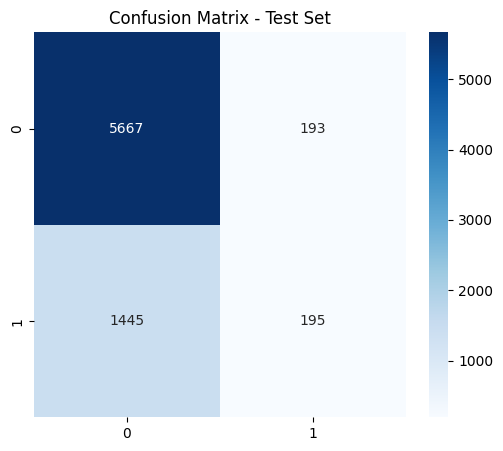

In [21]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


# Convert all datasets to NumPy arrays before training
xgb_model.fit(x_train_adv, y_train_subset,  verbose=False)

# Predictions on the test set (not the original or adversarial training data)
y_pred_test = xgb_model.predict(X_test_og)

# Compute accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on Test Set: {accuracy_test * 100:.2f}%")

# Confusion Matrix for test data
cm_test = confusion_matrix(y_test, y_pred_test)

# Plot Confusion Matrix for the test set
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()


In [22]:
def label_flip_attack(y_train: np.ndarray, flip_percent: float) -> np.ndarray:
    """
    Flip labels in y_train by a specified percentage.
    
    Args:
        y_train (np.ndarray): Original training labels.
        flip_percent (float): Percentage of labels to flip (0-100).

    Returns:
        np.ndarray: Poisoned labels with flipped values.
    """
    y_poisoned = y_train.copy()
    n_samples = len(y_train)
    n_flip = int((flip_percent / 100) * n_samples)  # Number of labels to flip
    
    flip_indices = np.random.choice(np.arange(n_samples), size=n_flip, replace=False)

    # Flip binary labels (assuming labels are 0 and 1)
    y_poisoned[flip_indices] = 1 - y_poisoned[flip_indices]  # Flip 0->1 and 1->0
    
    return y_poisoned



Accuracy on Test Set: 73.57%


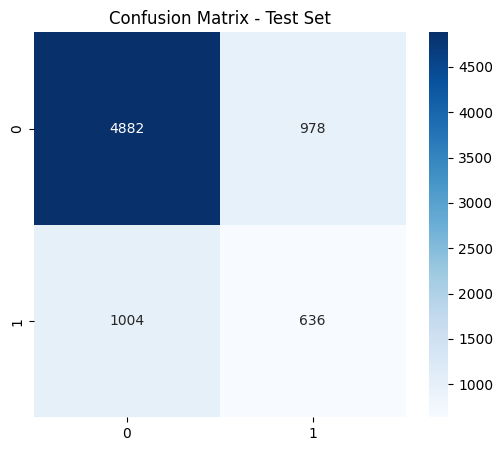

In [23]:
# Define the percentage of labels to flip
flip_percent = 35  # Flip 20% of labels

# Apply label flipping attack
y_train_poisoned = label_flip_attack(y_train, flip_percent)

# Step 2: Train model on poisoned labels
xgb_model.fit(X_train_og, y_train_poisoned, verbose=False)

# Step 3: Evaluate model on test set
y_pred_test = xgb_model.predict(X_test_og)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on Test Set: {accuracy_test * 100:.2f}%")

# Step 4: Confusion Matrix
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()